## Intersection - Test Bench
This  notebook is used to evaluate the performance regarding intersection operations of a compression algorithm.

NOTE: correctness is not checked here. That is done in "Intersection_Sketching.ipynb".

It is written such that a new compression algorithm can be added without altering the bench (just change the input in the config).

In [1]:
# ADD NEW ALGORITHMS HERE
from algos.alg_wkt import Wkt
from algos.alg_wkb import Wkb
from algos.alg_meta_wkb_comp import MetaWkbComp # Wkb with Metadat
from algos.alg_meta_wkt_comp import MetaWktComp # Wkt with Metadat
from algos.alg_wkb_comp import WkbComp
from algos.alg_wkt_comp import WktComp
from algos.alg_fpd import Fpd
from algos.alg_fpd_extended import FpdExtended
from algos.alg_fpd_predictor import FpdPredictor
import algos.fpd_extended_lib.cfg as cfg

In [2]:
import time
import os
from enum import Enum
import pandas as pd
from datetime import datetime
import filecmp
import random
import json
import tqdm
from shapely.geometry import shape
import glob
import timeit
import shapely
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from intersection.chunk_bbox_intersection import common_bbox
import geopandas as gpd
from bench_utils import parse_intersection_data 


In [22]:
# Constants

#Algorithm to be tested
ALG = FpdExtended()
ALG_FPDE = FpdExtended() #KEEP

# Number of total iterations = NBR_ITER * N * number_of_datasets
NBR_ITER = 1 # Number of iterations for each dataset
N = 1 # Number of times to recalculate each geometry for reliable mean value

# Geometry category variables
LARGE_THRESHOLD = 50

SHOW_PRED = True
SHOW_SHAPE = True
SHOW_STATS = False
SHOW_PREVIOUS = False



In [23]:
manual_data, _ = parse_intersection_data("manual")
world_data, world_data_stats = parse_intersection_data("world.json")
lund_data, lund_data_stats = parse_intersection_data("lund.json")
tricky_data, tricky_data_stats = parse_intersection_data("latest_export.json")

#Comment out the datasets to do not want to activate
datasets = [
           (manual_data, 15), 
           (world_data, 15), 
           (lund_data, 3),
           (tricky_data, 15)
           ]

In [26]:
# List the metrics which are to be logged
ET = Enum('ET', ['NO_BBOX', 'FALSE_IN_BBOX', 'TRUE_NO_CONTAINS', 'CONTAINS'
]) # EVAL_TYPE

ST = Enum('ET', ['SMALL', 'MIXED', 'LARGE'
]) # EVAL_TYPE


SEED = 123 # If we want to enforce the same ordering and indexes for multiple runs, else None
#SEED = random.randint(0, 9999999999999999)
random.seed(SEED) # Init random


### Benchmarking
Run the compression, decompression, along with the operations, and store the measurements. Done NBR_ITER times to average.

In [27]:
def evaluate_dataset(data, res, chk_max_size=None):
    if  chk_max_size != None:
        cfg.MAX_NUM_DELTAS = chk_max_size

    max_idx = len(data) - 1
    print("Number of queries:", len(data))
    if NBR_ITER != -1:
        idxs = [random.randint(0, max_idx) for i in range(NBR_ITER)] # Generate list of indexes to query on
    else:
        idxs = list(range(max_idx + 1))
    
    geom_vertex_cnt = []
    for i in tqdm.tqdm(idxs):
        g1, g2 = data[i]
        geom_vertex_cnt.append([shapely.get_num_coordinates(g1), shapely.get_num_coordinates(g2)])
        _, b1 = ALG.compress(g1)
        _, b2 = ALG.compress(g2)

        if SHOW_PRED:
            t_pred = timeit.timeit(lambda: ALG.is_intersecting((b1, b2)), number=N) / N
        if SHOW_SHAPE:
            t_shape = timeit.timeit(lambda: ALG.intersection((b1, b2)), number=N) / N

        b1_fpde = b1
        b2_fpde = b2
        if ALG != FpdExtended:
            _, b1_fpde = ALG_FPDE.compress(g1)
            _, b2_fpde = ALG_FPDE.compress(g2) 
        bbox = common_bbox((b1_fpde, b2_fpde))
        intersects = shapely.intersection(g1, g2)
        contains = shapely.contains(g1, g2) or shapely.contains(g2, g1)
        if not bbox:
            et = ET.NO_BBOX
        elif not intersects:
            et = ET.FALSE_IN_BBOX
        elif not contains:
            et = ET.TRUE_NO_CONTAINS
        else:
            et = ET.CONTAINS

        s1, s2 = (shapely.get_num_coordinates(g1), shapely.get_num_coordinates(g2))
        if s1 < LARGE_THRESHOLD and s2 < LARGE_THRESHOLD:
            sz = ST.SMALL
        elif s1 >= LARGE_THRESHOLD and s2 >= LARGE_THRESHOLD:
            sz = ST.LARGE
        else:
            sz = ST.MIXED

        if SHOW_PRED:
            res.append(('PRED_' + str(sz)[3:] + '_' + str(et)[3:], t_pred))
        if SHOW_SHAPE:
            res.append(('SHAPE_' + str(sz)[3:] + '_' + str(et)[3:], t_shape))
    
    if SHOW_STATS:
        print(np.average(geom_vertex_cnt))
        print(geom_vertex_cnt)

In [28]:
res = []
for dataset in datasets:
    evaluate_dataset(dataset[0], res, dataset[1]) # Second param: PLOT?

df = pd.DataFrame(res, columns=['type', 'time'])
#df

Number of queries: 7


100%|██████████| 1/1 [00:00<00:00, 241.72it/s]


Number of queries: 15342


100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


Number of queries: 39402


100%|██████████| 1/1 [00:00<00:00, 331.57it/s]


Number of queries: 11


100%|██████████| 1/1 [00:00<00:00, 83.02it/s]


### Plot the Results

In [29]:
averages = df.copy()
averages.loc['mean'] = averages.mean(numeric_only=True)
averages = averages.iloc[-1]

baseline_file = 'intersection_baseline.csv'
if os.path.exists(baseline_file):
    baseline = pd.read_csv(baseline_file)
    baseline['Algorithm'] = 'Baseline'
else:
    baseline_file = None

Total time for Baseline: 0.07576481299999788
Total time for FpdExtended: 0.03134116100011397


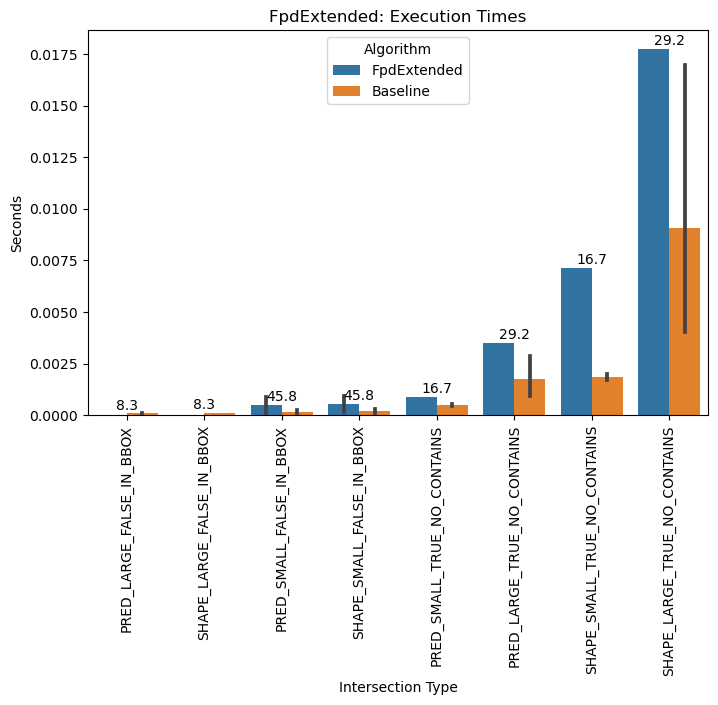

In [30]:
times = df.copy()
times['Algorithm'] = ALG.__class__.__name__

if baseline_file != None:
    times = pd.concat([times, baseline])
    total_time = sum(baseline["time"])
    print(f"Total time for Baseline: {total_time}")

prevs = glob.glob(f'reports/intersection_{ALG.__class__.__name__}*')
if len(prevs) != 0 and SHOW_PREVIOUS:
    prevs.sort()
    prev = pd.read_csv(prevs[-1])
    prev['Algorithm'] = 'Previous'
    times = pd.concat([times, prev])
    
times_order = times.groupby('type').apply(lambda x: x.time.mean()).sort_values().keys()
percent = (times.type.value_counts(normalize=True) * (200 if (SHOW_PRED and SHOW_SHAPE) else 100)).apply(lambda x: round(x, 1))

times_algo_avg = times.groupby(['type', 'Algorithm']).apply(lambda x: x.time.mean())
plt.figure(figsize=(8, 5))
for idx, i in enumerate(times_order):
    plt.annotate(percent[i], (idx, max(times_algo_avg[i]) + 0.00005), ha="center", va="bottom")
sns.barplot(data=times, x="type", y='time', hue="Algorithm", order=times_order)

plt.xticks(rotation=90)
plt.ylabel('Seconds');
plt.xlabel('Intersection Type');
plt.title(ALG.__class__.__name__ + ": Execution Times");

total_time = sum(df["time"])
print(f"Total time for {ALG.__class__.__name__ }: {total_time}")

### Export to CSV

In [ ]:
#df.to_csv("reports/intersection_" + ALG.__class__.__name__ + "_" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S") + ".csv", index=False)
#df.to_csv("intersection_baseline.csv", index=False)